### Multi-session user predictions
From our previous work, the measuring behaviours paper, we have produced a set of predictions for participants with multiple recorded sessions. While this approach focused on the low-level interaction data (the mouse movements, etc.), it still has validity here. I think, ultimately, if we're comparing participants that experienced some form of technical difficulty (mainly video buffering issues) against those that did not (or least did not report that they did), we should compare their real session against the technical difficulties participants.

Why do I think this?
Well, to start, it'll remove some noise from the data -- the mixture of 'test' and 'real' session isn't helping during the data exploration stage, i.e. comparing the two sets of participants. I hope that this might help provide some more distinction between the two sets of participants. Secondly, it provides a more interesting angle for the paper itself: we have this raw data with multiple sessions mixed in, we've made these predictions and presumptions, here are the resulting comparisons, let's then model the technical difficulties, then... test somehow.

In [33]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

pd.options.mode.chained_assignment = None  # default='warn'

First, let's import the prediction data. This is sourced from the results of the measuring behaviours paper, and it contains a prediction based on the descriptive statistics extracted from the truly low-level interaction data (i.e. microbehaviours).

In [34]:
predictions_df = pd.read_csv('./data/predictions.csv')
predictions_df.head()

,mb.value.mouseMoveBehaviour.totalDistance,mb.value.mouseMoveBehaviour.mouseOverCount,mb.value.mouseMoveBehaviour.mouseMoveCount,mb.value.eventsInEpisodeCounter,mb.value.episodeDurationms,mb.value.generalStatistics.count,mb.value.generalStatistics.timeDifference,mb.value.mouseStatistics.calculatedActiveTimeMedian,mb.value.mouseStatistics.urlEpisodeLength,mb.value.mouseStatistics.episodeUrlActivity,mbs.value.idleTimeCounter,mbs.value.totalIdleTime,prediction,key,sid
0,3321.291712,8.0,8.0,16.0,35201.0,16.0,35201.0,13910.5,35201.0,35201.0,1.0,26549.0,1,211_1.0_cake.pilot,211
1,96749.655528,49.0,108.0,157.0,4022020.0,157.0,4022020.0,152598.0,4022068.0,246306.0,25.0,3942179.0,0,211_2.0_cake.pilot,211
2,28563.292056,14.0,29.0,43.0,227732.0,43.0,227732.0,364900.0,227743.0,149266.0,9.0,223176.0,1,211_3.0_cake.pilot,211
3,37148.157739,31.0,50.0,81.0,208522.0,81.0,208522.0,48957.0,208544.0,208544.0,9.0,145515.0,0,223_1.0_cake.pilot,223
4,66658.302976,49.0,81.0,130.0,1852062.0,130.0,1852062.0,403648.0,1852062.0,290841.0,17.0,971967.0,0,223_2.0_cake.pilot,223


So, as you can see from the data frame above (sorry about the column name mess, it's a from a flattened JSON document!) there is a prediction, key, and sid. The prediction is the class that the SVM classifier thinks the session belongs to (__0 == live__ and __1 == test__). The key is a combination of the participant id, the session number, and the url that their experience was hosted on (originally useful information in the pre-processing step but not in this context). Finally, the sid is just the identification number to provided to each of the participants in the CAKE experience study.

What we need to do is extract the session number out of the key, so we're able to add a column to the data frame consisting of the session number. Let's do it:

In [35]:
def split_key_get_session(row):
    split = row['key'].split('_') # split by the underscore
    return int(float(split[1])) # make an integer to remove the .0 

predictions_df['session'] = predictions_df.apply(split_key_get_session, axis=1)
predictions_df.head()

,mb.value.mouseMoveBehaviour.totalDistance,mb.value.mouseMoveBehaviour.mouseOverCount,mb.value.mouseMoveBehaviour.mouseMoveCount,mb.value.eventsInEpisodeCounter,mb.value.episodeDurationms,mb.value.generalStatistics.count,mb.value.generalStatistics.timeDifference,mb.value.mouseStatistics.calculatedActiveTimeMedian,mb.value.mouseStatistics.urlEpisodeLength,mb.value.mouseStatistics.episodeUrlActivity,mbs.value.idleTimeCounter,mbs.value.totalIdleTime,prediction,key,sid,session
0,3321.291712,8.0,8.0,16.0,35201.0,16.0,35201.0,13910.5,35201.0,35201.0,1.0,26549.0,1,211_1.0_cake.pilot,211,1
1,96749.655528,49.0,108.0,157.0,4022020.0,157.0,4022020.0,152598.0,4022068.0,246306.0,25.0,3942179.0,0,211_2.0_cake.pilot,211,2
2,28563.292056,14.0,29.0,43.0,227732.0,43.0,227732.0,364900.0,227743.0,149266.0,9.0,223176.0,1,211_3.0_cake.pilot,211,3
3,37148.157739,31.0,50.0,81.0,208522.0,81.0,208522.0,48957.0,208544.0,208544.0,9.0,145515.0,0,223_1.0_cake.pilot,223,1
4,66658.302976,49.0,81.0,130.0,1852062.0,130.0,1852062.0,403648.0,1852062.0,290841.0,17.0,971967.0,0,223_2.0_cake.pilot,223,2


Now, let's get all of the data that has been prediction as a 'real' session.

In [36]:
real_session_preds = predictions_df[predictions_df['prediction'] == 0]
real_session_preds.head(20)

,mb.value.mouseMoveBehaviour.totalDistance,mb.value.mouseMoveBehaviour.mouseOverCount,mb.value.mouseMoveBehaviour.mouseMoveCount,mb.value.eventsInEpisodeCounter,mb.value.episodeDurationms,mb.value.generalStatistics.count,mb.value.generalStatistics.timeDifference,mb.value.mouseStatistics.calculatedActiveTimeMedian,mb.value.mouseStatistics.urlEpisodeLength,mb.value.mouseStatistics.episodeUrlActivity,mbs.value.idleTimeCounter,mbs.value.totalIdleTime,prediction,key,sid,session
1,96749.655528,49.0,108.0,157.0,4022020.0,157.0,4022020.0,152598.0,4022068.0,246306.0,25.0,3942179.0,0,211_2.0_cake.pilot,211,2
3,37148.157739,31.0,50.0,81.0,208522.0,81.0,208522.0,48957.0,208544.0,208544.0,9.0,145515.0,0,223_1.0_cake.pilot,223,1
4,66658.302976,49.0,81.0,130.0,1852062.0,130.0,1852062.0,403648.0,1852062.0,290841.0,17.0,971967.0,0,223_2.0_cake.pilot,223,2
5,22796.538636,25.0,35.0,60.0,1136137.0,60.0,1136137.0,161522.5,1181217.0,277892.0,13.0,1090067.0,0,225_1.0_cake.pilot,225,1
7,73436.896459,37.0,49.0,86.0,2901106.0,86.0,2901106.0,358570.0,2901106.0,89765.0,11.0,1299866.0,0,225_6.0_cake.pilot,225,6
10,87142.176146,62.0,110.0,172.0,2233846.0,172.0,2233846.0,107734.5,2235324.0,234136.0,24.0,2030386.0,0,114_2.0_cake.pilot,114,2
12,125429.089511,55.0,62.0,117.0,2664194.0,117.0,2664194.0,204075.0,2698125.0,242278.0,18.0,2165893.0,0,117_2.0_cake.pilot,117,2
14,57798.832895,39.0,120.0,159.0,3449169.0,159.0,3449169.0,248569.0,3453368.0,455282.0,25.0,2881449.0,0,124_2.0_cake.pilot,124,2
16,50457.556013,34.0,43.0,77.0,2582810.0,77.0,2582810.0,244863.0,2616460.0,141211.0,14.0,2495735.0,0,127_2.0_cake.pilot,127,2
19,32189.672590,18.0,48.0,66.0,394547.0,66.0,394547.0,134070.5,397891.0,219953.0,12.0,380152.0,0,405_1.0_cake.pilot,405,1


As you can see, even in a small amount of information, some users still have multiple sessions classified as as 'real' sessions. Is this a problem? Probably not, it could be reasonable for someone to have two sessions predicted as 'real'. The key point here is that it does helps to reduce the amount of, potential, noise in the data.

Now what we need to do, if we can, is separate out the (predicted) real sessions from the (predicted) non-real sessions in the other data set -- the button click statistics!

In [37]:
btn_click_stats = pd.read_csv('./data/live-interactions_statistics_results.csv') # read in

# Let's not worry about the linear participants just yet.
# Create a column in both that combines the id and the session number
btn_click_stats['temp_col'] = btn_click_stats[['userid', 'sessionNo']].apply(lambda x: ''.join(x.astype(str)), axis=1)
real_session_preds['temp_col'] = real_session_preds[['sid', 'session']].apply(lambda x: ''.join(x.astype(str)), axis=1)

# Find were those temporary values are equal and drop the rest
btn_click_real_pred_stats = btn_click_stats[btn_click_stats['temp_col'].isin(real_session_preds['temp_col'].values)]
#btn_click_real_pred_stats.drop('temp_col', axis=1, inplace=True)
btn_click_real_pred_stats.head()

,userid,sessionNo,totalEvents,totalTime,totalTimeBetweenClicks,meanTimeBetweenClicks,stdTimeBetweenClicks,meanClicksPerSecond,stdClicksPerSecond,meanClicksPerMinute,stdClicksPerMinute,mostFrequentItemAction,temp_col
2,310,3,59,2794,2794,47.355932,87.028684,1.180000,0.437526,2.360000,2.413158,892570 v4,3103
6,223,1,7,175,175,25.000000,30.697448,1.000000,0.000000,1.750000,0.957427,0 play_pause_button,2231
7,223,2,45,1782,1782,39.600000,37.250015,1.000000,0.000000,1.800000,1.080123,0 next_button,2232
31,317,1,21,4373,4373,208.238095,375.835989,1.105263,0.315302,1.615385,0.869718,205779 v4,3171
33,225,1,51,1204,1204,23.607843,45.690296,1.062500,0.244623,3.642857,4.106414,0 next_button,2251


Now that we've split the two up, let's look at how this affects the plots that are produced in the other (exploratory-time-series) notebook. We first need to create the total time in minute column.

In [38]:
def get_mins(x):
    min, sec = divmod(x, 60)
    return float('{}.{}'.format(min, sec))

btn_click_real_pred_stats['totalTimeMin'] = btn_click_real_pred_stats['totalTime'].apply(get_mins)

Let's now compare some of the plots to one another.

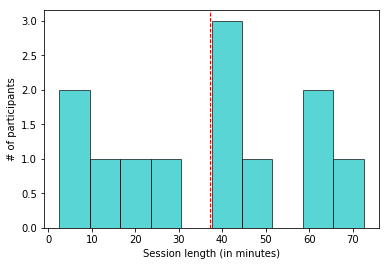

In [39]:
# Plot the histogram for the length of the session
plt.figure()
plt.hist(btn_click_real_pred_stats['totalTimeMin'], bins=10, edgecolor='k', alpha=0.65, color='c')
plt.xlabel('Session length (in minutes)')
plt.ylabel('# of participants')
plt.axvline(btn_click_real_pred_stats['totalTimeMin'].mean(), color='r', linestyle='dashed', linewidth=1)

In [40]:
""" Replicate some of the steps that are in the other notebook. """
# Technical Diff Stats
td_stats = pd.read_csv('./data/technical-difficult-interactions_results.csv') 

# Get the total minutes
td_stats['totalTimeMin'] = td_stats['totalTime'].apply(get_mins)

# Drop this column
td_stats.drop(['mostFrequentItemAction'], inplace=True, axis=1)

# Drop these columns
btn_click_real_pred_stats.drop(['sessionNo', 'mostFrequentItemAction'], inplace=True, axis=1)

# Get the raw interaction data and drop the id and condition columns
cake_raw_data = pd.read_csv('./data/cake_alone_interactions.csv')
cake_raw_data.drop(['id', 'condition'], axis=1, inplace=True)

# select the stats for the cake data users, ignoring the linear participants
cake_raw_data_stats = btn_click_real_pred_stats[btn_click_real_pred_stats['userid'].isin(cake_raw_data['participant_id'].unique())]

# select the technical difficulties users that are cake users, ignoring the linear participants.
cake_tech_diff_users = [109, 407, 205, 121, 112, 220, 217, 113]
cake_td_stats = td_stats[td_stats['userid'].isin(cake_tech_diff_users)]

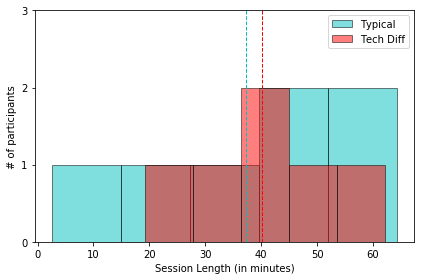

In [41]:
cake_td_stats = cake_td_stats.drop(cake_td_stats[cake_td_stats['userid'] == 407].index)
cake_td_stats = cake_td_stats.drop(cake_td_stats[cake_td_stats['userid'] == 109].index)
plt.figure()
plt.hist(cake_raw_data_stats['totalTimeMin'], bins=5, alpha=0.5, label='Typical', edgecolor='k', color='c')
plt.hist(cake_td_stats['totalTimeMin'], bins=5, alpha=0.5, label='Tech Diff', edgecolor='k', color='r')
plt.legend()
plt.xlabel('Session Length (in minutes)')
plt.ylabel('# of participants')
plt.axvline(cake_td_stats['totalTimeMin'].mean(), color='r', linestyle='dashed', linewidth=1)
plt.axvline(cake_raw_data_stats['totalTimeMin'].mean(), color='c', linestyle='dashed', linewidth=1)
plt.yticks([0, 1, 2, 3])
plt.tight_layout()
plt.savefig('pred-session-length-hist.png', dpi=300)

The plot above seems to highlight, again, how similar the two sets of users are.

The intensity of interactions over time needs to be done within this context -- where the predicted sessions are used rather than every session that has been recorded by the typical participant. Luckly enough, we should be able to use the same code that has been previously written to produce these plots.

In [42]:
# This code will produce a dictionary that has the signature: {id : [(5min increments, event count), ...]}. The idea for this is so we can 
# compare the number of events over time (see notebook for plot idea). This should probably be changed to a function.
from collections import defaultdict
def get_intensity_plot_data(dataframe, id_col_name, time_col_name, interval_period, time_period_str):
    plot_data = defaultdict(list)
    for uid in dataframe[id_col_name].unique():
        internal_df = pd.DataFrame(dataframe[dataframe[id_col_name] == uid])
        internal_df.set_index(time_col_name, inplace=True)
        internal_df.index = pd.to_datetime(internal_df.index)
        internal_df['count'] = 1
        internal_period = interval_period
        data = internal_df.groupby(pd.Grouper(freq=time_period_str)).aggregate(np.sum)
        for val in data['count']:
            plot_data[uid].append(tuple([internal_period, val]))
            internal_period += interval_period
    return plot_data

In [43]:
# we still have the temporary column, we're going to need this to split off the data in the 
# raw, non-technical difficulties data!
cake_raw_data_stats.head()

,userid,totalEvents,totalTime,totalTimeBetweenClicks,meanTimeBetweenClicks,stdTimeBetweenClicks,meanClicksPerSecond,stdClicksPerSecond,meanClicksPerMinute,stdClicksPerMinute,temp_col,totalTimeMin
6,223,7,175,175,25.000000,30.697448,1.000000,0.000000,1.750000,0.957427,2231,2.55
7,223,45,1782,1782,39.600000,37.250015,1.000000,0.000000,1.800000,1.080123,2232,29.42
33,225,51,1204,1204,23.607843,45.690296,1.062500,0.244623,3.642857,4.106414,2251,20.40
36,211,71,3866,3866,54.450704,81.405298,1.028986,0.168995,1.972222,1.594385,2112,64.26
41,124,50,3553,3553,71.060000,117.268471,1.000000,0.000000,1.851852,1.561649,1242,59.13


In [44]:
# read in the raw data with the session number attached
live_inter_sess = pd.read_csv('./data/live-interactions_sessions.csv')

# drop the technical difficulties users
live_inter_sess = live_inter_sess.drop(live_inter_sess[live_inter_sess['userId'].isin(cake_tech_diff_users)].index)

# drop the non-cake participants!
live_inter_sess = live_inter_sess.drop(live_inter_sess[live_inter_sess['userId'].isin(cake_raw_data['participant_id'].unique())].index)

live_inter_sess['comb_id_sess'] = live_inter_sess[['userId', 'sessionNo']].astype(str).apply(lambda x: ''.join(x), axis=1)

live_inter_sess.head()

,id,userId,timestamp,item,action,sessionNo,comb_id_sess
0,1,310,2017-08-17T12:01:12,14508,window,1,3101
1,2,310,2017-08-17T12:01:12,14641,window,1,3101
2,3,310,2017-08-17T12:01:18,20640,tab-r3,1,3101
3,4,310,2017-08-17T12:01:19,22327,tab-r2,1,3101
4,5,310,2017-08-17T12:01:42,45280,window,1,3101


In [45]:
# now let's drop the data that hasn't been predicted as the real session
# btn_click_real_pred_stats = btn_click_stats[btn_click_stats['temp_col'].isin(real_session_preds['temp_col'].values)]
live_inter_sess[live_inter_sess['comb_id_sess'].isin(cake_raw_data_stats['temp_col'].values)]

,id,userId,timestamp,item,action,sessionNo,comb_id_sess
